# Ensemble Classification

### 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style(style='darkgrid')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
import lightgbm as lgb

from custom_stacking import CustomStackingClassifier
import time
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
SEED = 42
np.random.seed(SEED)

### 2. Data Preparation and Splitting

In [4]:
DATA_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data', 'RHMD_Engineered.csv')
df = pd.read_csv(DATA_PATH)

In [5]:
mentalhealth_df = df[df['subreddit'] == 'mentalhealth'].copy()
df = df[df['subreddit'] != 'mentalhealth'].copy()

In [6]:
print(f"Number of posts from specific mental health subreddits: {len(df)}")
print(f"Number of general mentalhealth posts to be classified: {len(mentalhealth_df)}")

Number of posts from specific mental health subreddits: 16178
Number of general mentalhealth posts to be classified: 4177


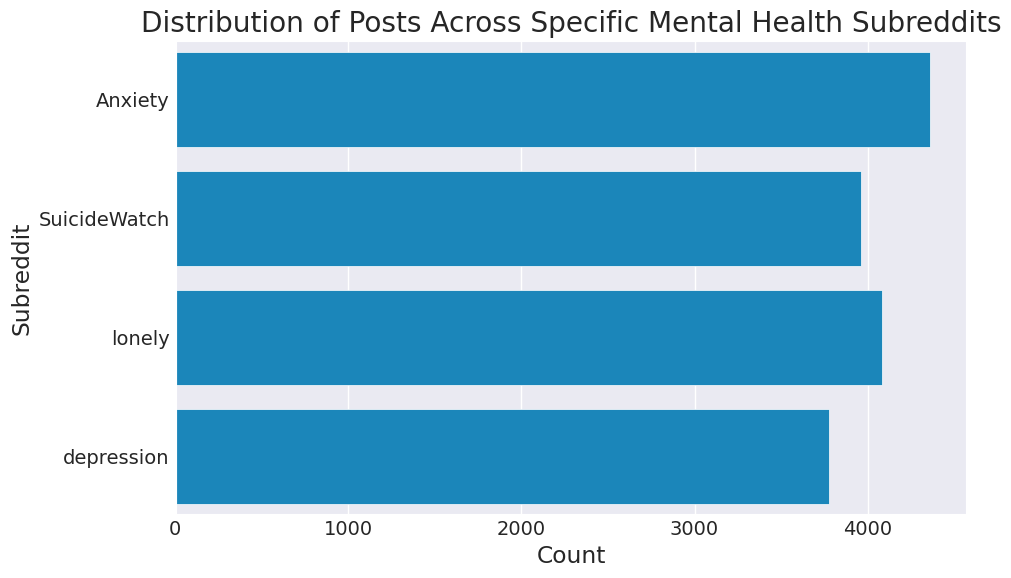

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(y='subreddit', data=df)
plt.title('Distribution of Posts Across Specific Mental Health Subreddits')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.show()

In [8]:
feature_columns = [
    'title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity',
    'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism',
    'title_word_count', 'text_word_count',
    'dominant_topic', 'topic_contribution',
    'distress_score'
]

In [9]:
existing_features = [col for col in feature_columns if col in df.columns]
print(f"Using {len(existing_features)} features for prediction:")
print(existing_features)

Using 21 features for prediction:
['title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity', 'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'pain', 'shame', 'violence', 'love', 'optimism', 'title_word_count', 'text_word_count', 'dominant_topic', 'topic_contribution', 'distress_score']


In [10]:
X = df[existing_features]
y = df['subreddit']

In [11]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
print("\nLabel encoding mapping:")
for i, subreddit in enumerate(label_encoder.classes_):
    print(f"{subreddit} -> {i}")


Label encoding mapping:
Anxiety -> 0
SuicideWatch -> 1
depression -> 2
lonely -> 3


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded)

In [14]:
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (12942, 21)
Testing set shape: (3236, 21)


In [15]:
X_mentalhealth = mentalhealth_df[existing_features]
print(f"Mentalhealth posts feature set shape: {X_mentalhealth.shape}")

Mentalhealth posts feature set shape: (4177, 21)


### 3. Feature Engineering for Different Model Architectures

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
pca = PCA(n_components=min(15, len(existing_features)))
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [18]:
selector = SelectKBest(f_classif, k=min(20, len(existing_features)))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [19]:
selected_indices = selector.get_support(indices=True)
selected_features = [existing_features[i] for i in selected_indices]
print("\nTop selected features based on ANOVA F-test:")
print(selected_features)


Top selected features based on ANOVA F-test:
['title_sentiment', 'text_sentiment', 'overall_sentiment', 'textblob_sentiment', 'textblob_subjectivity', 'negative_emotion', 'positive_emotion', 'sadness', 'fear', 'death', 'suffering', 'shame', 'violence', 'love', 'optimism', 'title_word_count', 'text_word_count', 'dominant_topic', 'topic_contribution', 'distress_score']



PCA explained variance ratio:
0.9501541893275544


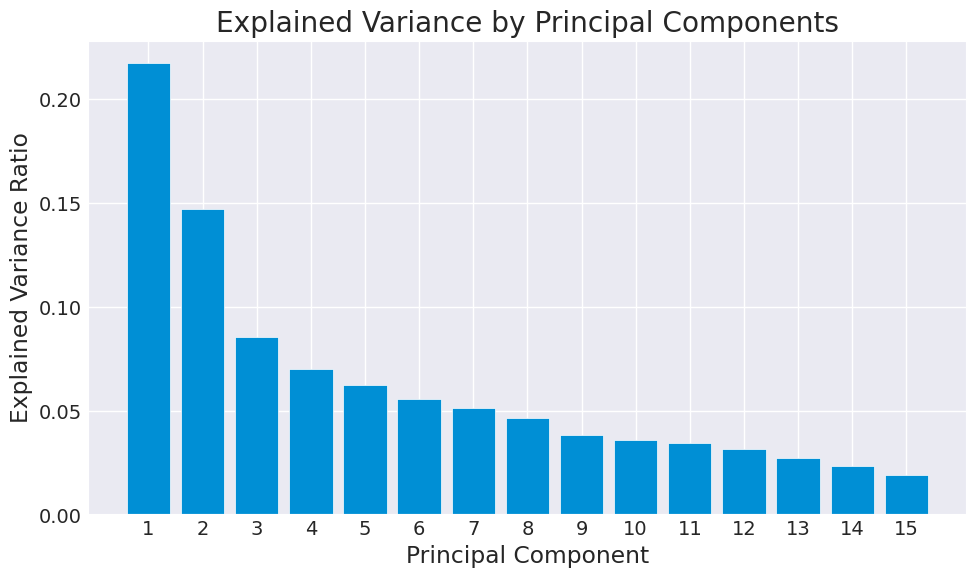

In [20]:
explained_variance = pca.explained_variance_ratio_
print("\nPCA explained variance ratio:")
print(sum(explained_variance))
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.tight_layout()
plt.show()

In [21]:
X_train_nn = X_train_scaled.copy()
X_test_nn = X_test_scaled.copy()

In [22]:
X_train_svm = X_train_scaled.copy()
X_test_svm = X_test_scaled.copy()

In [23]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [24]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

In [25]:
X_train_lr = X_train_pca.copy()
X_test_lr = X_test_pca.copy()

### 4. Base Model Training and Evaluation

In [26]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {train_time:.2f}s")

    return model, accuracy, f1, train_time, y_pred

In [27]:
models = {
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        alpha=0.0001,
        max_iter=300,
        random_state=SEED
    ),
    "SVM": SVC(
        C=1.0,
        kernel='rbf',
        probability=True,
        random_state=SEED
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=SEED
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        colsample_bytree=0.65,
        minnum_leaves=68,
        reg_alpha=10,
        reg_lambda=5.5,
        subsample=1,
        random_state=SEED
    ),
    "Logistic Regression": LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=SEED
    )
}

In [28]:
results = {}
predictions = {}

In [29]:
for name, model in models.items():
    if name == "Neural Network":
        trained_model, acc, f1, time_taken, preds = evaluate_model(
            model, X_train_nn, X_test_nn, y_train, y_test, name
        )
    elif name == "SVM":
        trained_model, acc, f1, time_taken, preds = evaluate_model(
            model, X_train_svm, X_test_svm, y_train, y_test, name
        )
    elif name == "Random Forest":
        trained_model, acc, f1, time_taken, preds = evaluate_model(
            model, X_train_rf, X_test_rf, y_train, y_test, name
        )
    elif name == "LightGBM":
        trained_model, acc, f1, time_taken, preds = evaluate_model(
            model, X_train_lgb, X_test_lgb, y_train, y_test, name
        )
    elif name == "Logistic Regression":
        trained_model, acc, f1, time_taken, preds = evaluate_model(
            model, X_train_lr, X_test_lr, y_train, y_test, name
        )

    results[name] = {
        'model': trained_model,
        'accuracy': acc,
        'f1': f1,
        'time': time_taken
    }
    predictions[name] = preds

Neural Network - Accuracy: 0.4978, F1: 0.4972, Time: 59.79s
SVM - Accuracy: 0.5538, F1: 0.5463, Time: 68.52s
Random Forest - Accuracy: 0.5637, F1: 0.5548, Time: 6.06s
[LightGBM] [Warning] Unknown parameter: minnum_leaves
[LightGBM] [Warning] Unknown parameter: minnum_leaves
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 12942, number of used features: 21
[LightGBM] [Info] Start training from score -1.311149
[LightGBM] [Info] Start training from score -1.407062
[LightGBM] [Info] Start training from score -1.455552
[LightGBM] [Info] Start training from score -1.376912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [30]:
base_results = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1 Score': [results[m]['f1'] for m in results]
})

In [31]:
base_results = base_results.sort_values('Accuracy', ascending=False)

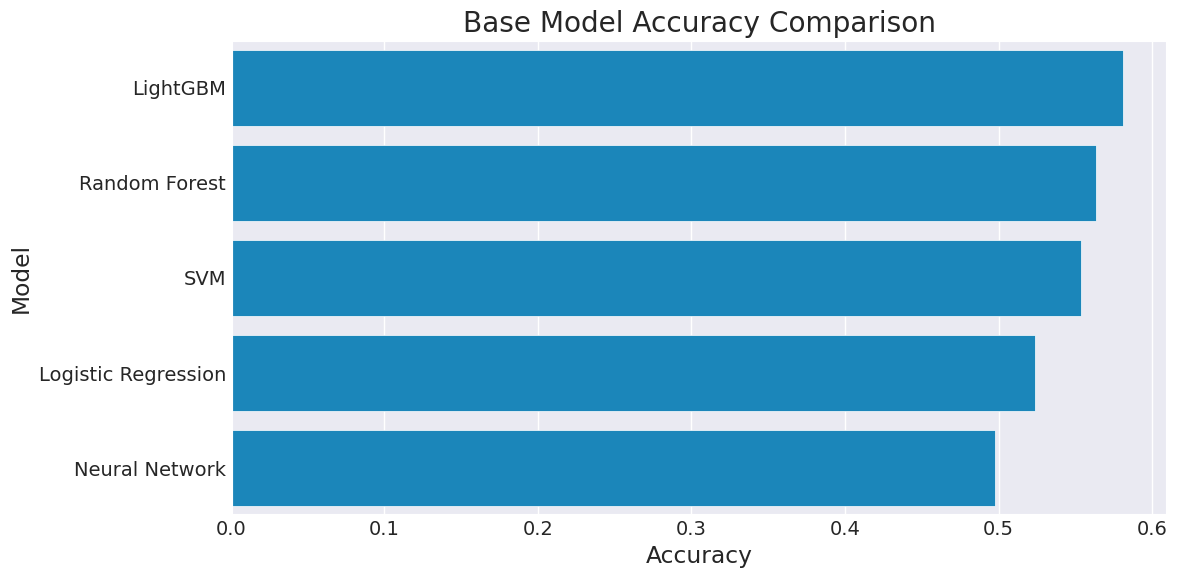

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=base_results)
plt.title('Base Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

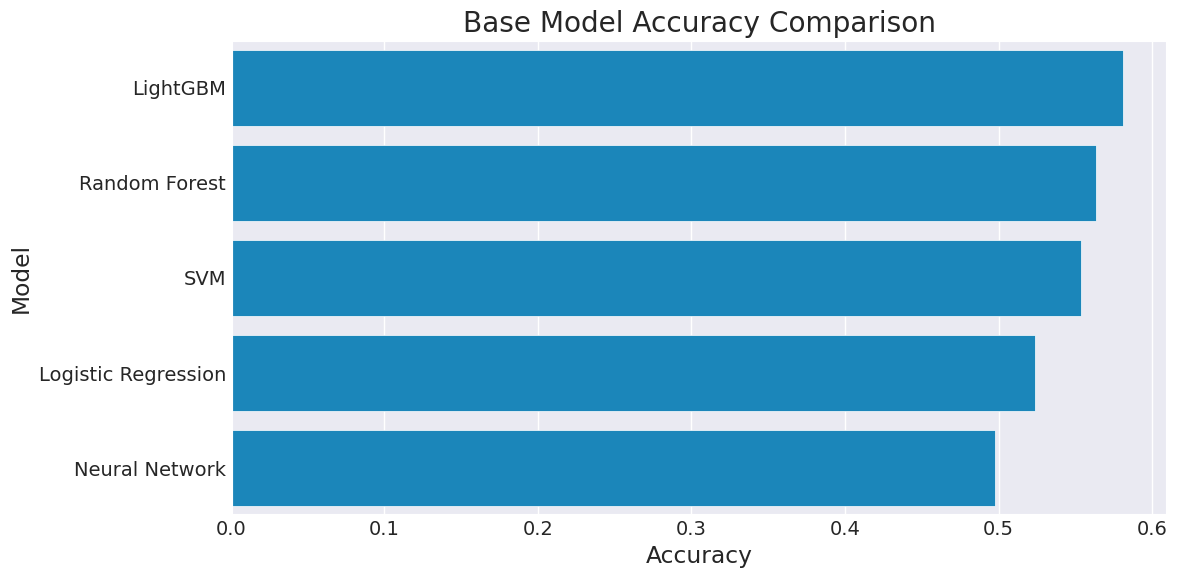

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=base_results)
plt.title('Base Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

### 5. Bagging With SVM

In [34]:
bagging_svm = BaggingClassifier(
    estimator=SVC(probability=True, random_state=SEED),
    n_estimators=10,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    random_state=SEED
)

In [35]:
bagging_svm, acc_svm, f1_svm, time_svm, preds_svm = evaluate_model(
    bagging_svm, X_train_svm, X_test_svm, y_train, y_test, "Bagging with SVM"
)

Bagging with SVM - Accuracy: 0.5494, F1: 0.5393, Time: 178.82s


In [36]:
print(f"Bagging with SVM - Accuracy: {acc_svm:.4f}, F1: {f1_svm:.4f}")

Bagging with SVM - Accuracy: 0.5494, F1: 0.5393


### 6. Voting

In [37]:
voting_clf = VotingClassifier(
    estimators=[
        ('nn', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', random_state=SEED)),
        ('svm', SVC(probability=True, random_state=SEED)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=SEED)),
        ('lgb', lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=8, colsample_bytree=0.65, min_child_samples=13, num_leaves=68, reg_alpha=10, reg_lambda=5.5, subsample=1, random_state=SEED))
    ],
    voting='soft'
)

In [38]:
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', random_state=SEED)
nn_model.fit(X_train_nn, y_train)

svm_model = SVC(probability=True, random_state=SEED)
svm_model.fit(X_train_svm, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_train_rf, y_train)

lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=8, colsample_bytree=0.65, minum_leaves=68, reg_alpha=10, reg_lambda=5.5, subsample=1, random_state=SEED)
lgb_model.fit(X_train_lgb, y_train)

[LightGBM] [Warning] Unknown parameter: minum_leaves
[LightGBM] [Warning] Unknown parameter: minum_leaves
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 12942, number of used features: 21
[LightGBM] [Info] Start training from score -1.311149
[LightGBM] [Info] Start training from score -1.407062
[LightGBM] [Info] Start training from score -1.455552
[LightGBM] [Info] Start training from score -1.376912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier(colsample_bytree=0.65, learning_rate=0.01, max_depth=8,
               minum_leaves=68, n_estimators=500, random_state=42, reg_alpha=10,
               reg_lambda=5.5, subsample=1)

In [39]:
voting_clf.estimators[0] = nn_model
voting_clf.estimators[1] = svm_model
voting_clf.estimators[2] = rf_model
voting_clf.estimators[3] = lgb_model
voting_clf._fitted = True

In [40]:
nn_pred_proba = nn_model.predict_proba(X_test_nn)
svm_pred_proba = svm_model.predict_proba(X_test_svm)
rf_pred_proba = rf_model.predict_proba(X_test_rf)
lgb_pred_proba = lgb_model.predict_proba(X_test_lgb)

[LightGBM] [Warning] Unknown parameter: minum_leaves


In [41]:
avg_pred_proba = (nn_pred_proba + svm_pred_proba + rf_pred_proba + lgb_pred_proba) / 4
voting_pred = np.argmax(avg_pred_proba, axis=1)

In [42]:
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_f1 = f1_score(y_test, voting_pred, average='weighted')

In [43]:
print(f"Voting Classifier - Accuracy: {voting_accuracy:.4f}, F1: {voting_f1:.4f}")

Voting Classifier - Accuracy: 0.5655, F1: 0.5580


In [44]:
bagging_and_voting_results = pd.DataFrame({
    'Model': ['Voting Classifier', 'Bagging with SVM'],
    'Accuracy': [voting_accuracy, acc_svm],
    'F1 Score': [voting_f1, f1_svm]
})

In [45]:
comparison_df = pd.concat([base_results, bagging_and_voting_results])
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

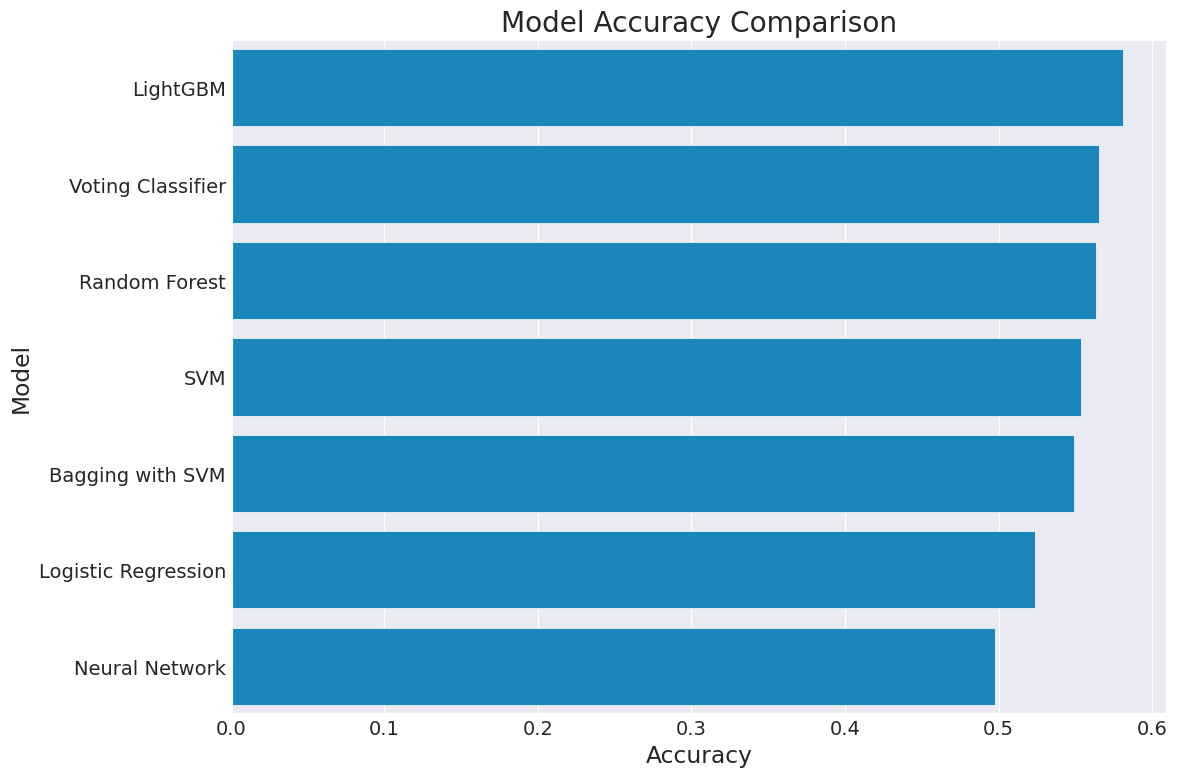

In [46]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

### 7. Stacking

In [61]:
base_models = [
    ('nn', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', random_state=SEED)),
    ('svm', SVC(probability=True, random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=SEED)),
    ('lgb', lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, max_depth=8, colsample_bytree=0.65, min_child_samples=13, num_leaves=68, reg_alpha=10, reg_lambda=5.5, subsample=1, random_state=SEED))
]

In [72]:
meta_model = LogisticRegression(C=1.0, max_iter=1000, random_state=SEED)

In [73]:
feature_sets = {
    'nn': [X_train_nn, X_test_nn],
    'svm': [X_train_svm, X_test_svm],
    'rf': [X_train_rf, X_test_rf],
    'lgb': [X_train_lgb, X_test_lgb]
}

In [74]:
stacking_clf = CustomStackingClassifier(
    base_models=base_models,
    meta_model=meta_model,
    feature_sets=feature_sets,
)

In [75]:
stacking_clf.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

CustomStackingClassifier(base_models=[('nn',
                                       MLPClassifier(hidden_layer_sizes=(100,
                                                                         50),
                                                     random_state=42)),
                                      ('svm',
                                       SVC(probability=True, random_state=42)),
                                      ('rf',
                                       RandomForestClassifier(random_state=42)),
                                      ('lgb',
                                       LGBMClassifier(colsample_bytree=0.65,
                                                      learning_rate=0.01,
                                                      max_depth=8,
                                                      min_child_samples=13,
                                                      n_estimators=500,
                                                      num_leaves=68,
                                                      random_state=42,
                                                      reg_alpha=...
       [-0.82362304, -1.09731612, -1.25923515, ...,  0.92574411,
        -1.0372888 ,  0.88405003],
       ...,
       [-1.86947607, -1.13898371, -1.74987079, ...,  0.92574411,
        -1.07591758,  1.17755726],
       [ 0.29568116,  0.68167326,  0.6879993 , ..., -0.45387765,
        -0.12272643, -0.45887407],
       [-0.72577287, -1.05781309, -1.18413673, ...,  0.58083867,
        -1.01118828,  1.35671349]])]},
                         meta_model=LogisticRegression(max_iter=1000,
                                                       random_state=42))

In [76]:
stacking_pred = stacking_clf.predict(X_test)

In [77]:
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_f1 = f1_score(y_test, stacking_pred, average='weighted')

In [78]:
print(f"Stacking Classifier - Accuracy: {stacking_accuracy:.4f}, F1: {stacking_f1:.4f}")

Stacking Classifier - Accuracy: 0.5850, F1: 0.5808


In [79]:
stacking_results = pd.DataFrame({
    'Model': ['Stacking Classifier'],
    'Accuracy': [stacking_accuracy],
    'F1 Score': [stacking_f1]
})

In [80]:
comparison_df = pd.concat([comparison_df, stacking_results])
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

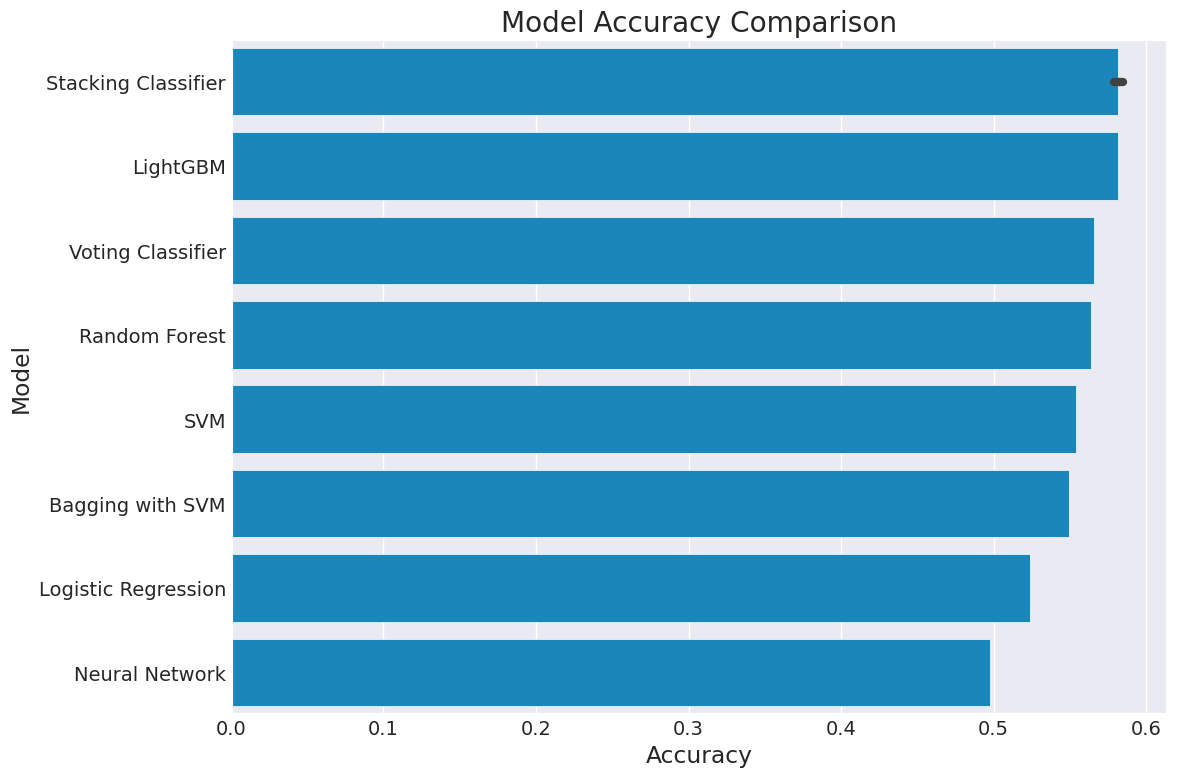

In [81]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Model', data=comparison_df)
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

In [82]:
best_model_name = comparison_df.iloc[comparison_df['Accuracy'].argmax()]['Model']
print(f"\nBest model based on accuracy: {best_model_name}")


Best model based on accuracy: Stacking Classifier


In [83]:
if best_model_name == 'Stacking Classifier':
    best_preds = stacking_pred
elif best_model_name == 'Voting Classifier':
    best_preds = voting_pred
elif best_model_name == 'Bagging-SVM':
        best_preds = preds_svm
else:
    model_key = best_model_name
    best_preds = predictions[model_key]

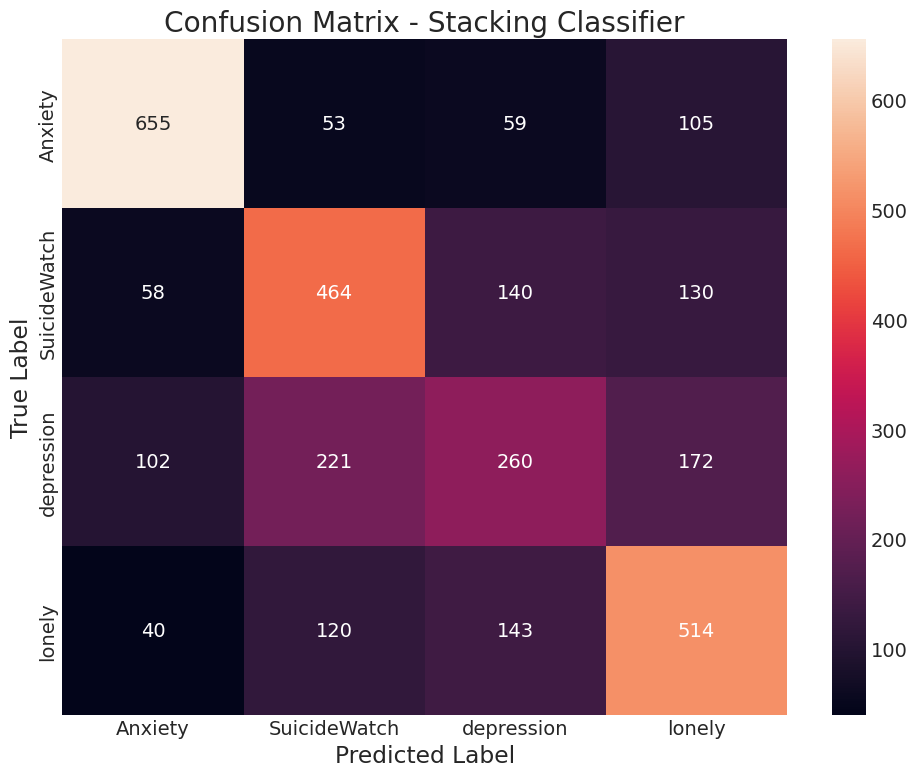

In [85]:
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [86]:
print("\nClassification Report for Best Model:")
print(classification_report(y_test, best_preds, target_names=label_encoder.classes_))


Classification Report for Best Model:
              precision    recall  f1-score   support

     Anxiety       0.77      0.75      0.76       872
SuicideWatch       0.54      0.59      0.56       792
  depression       0.43      0.34      0.38       755
      lonely       0.56      0.63      0.59       817

    accuracy                           0.58      3236
   macro avg       0.57      0.58      0.57      3236
weighted avg       0.58      0.58      0.58      3236



### 8. Classifying Mentalhealth Posts

In [87]:
X_mentalhealth_nn = scaler.transform(X_mentalhealth)
X_mentalhealth_svm = scaler.transform(X_mentalhealth)
X_mentalhealth_rf = X_mentalhealth.copy()
X_mentalhealth_lgb = X_mentalhealth.copy()
X_mentalhealth_lr = pca.transform(scaler.transform(X_mentalhealth))

In [88]:
feature_sets_pred = {
    'nn': (X_train_nn, X_mentalhealth_nn),
    'svm': (X_train_svm, X_mentalhealth_svm),
    'rf': (X_train_rf, X_mentalhealth_rf),
    'lgb': (X_train_lgb, X_mentalhealth_lgb)
}

In [89]:
stacking_clf.feature_sets = feature_sets_pred
mentalhealth_preds = stacking_clf.predict(X_mentalhealth)
mentalhealth_probs = stacking_clf.predict_proba(X_mentalhealth)

In [90]:
mentalhealth_df['predicted_label'] = mentalhealth_preds
mentalhealth_df['predicted_subreddit'] = label_encoder.inverse_transform(mentalhealth_preds)

In [91]:
for i, class_name in enumerate(label_encoder.classes_):
    mentalhealth_df[f'prob_{class_name}'] = mentalhealth_probs[:, i]

In [92]:
mentalhealth_df['confidence'] = mentalhealth_probs.max(axis=1)

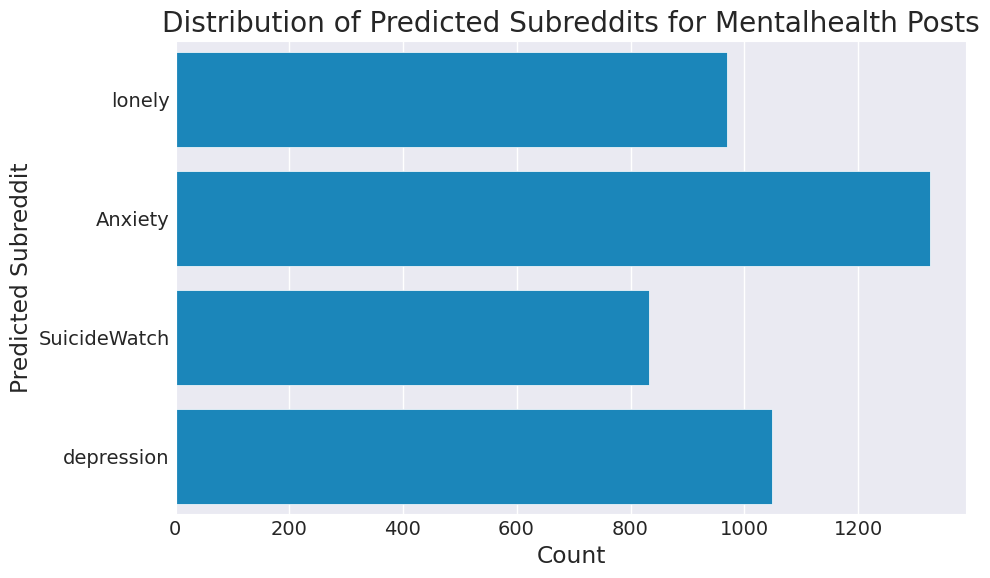

In [93]:
plt.figure(figsize=(10, 6))
sns.countplot(y='predicted_subreddit', data=mentalhealth_df)
plt.title('Distribution of Predicted Subreddits for Mentalhealth Posts')
plt.xlabel('Count')
plt.ylabel('Predicted Subreddit')
plt.tight_layout()
plt.show()

In [94]:
predicted_counts = mentalhealth_df['predicted_subreddit'].value_counts()
predicted_percentages = predicted_counts / predicted_counts.sum() * 100

In [95]:
print("\nDistribution of mentalhealth posts into specific subreddits:")
for subreddit, percentage in predicted_percentages.items():
    print(f"{subreddit}: {percentage:.2f}%")


Distribution of mentalhealth posts into specific subreddits:
Anxiety: 31.75%
depression: 25.11%
lonely: 23.22%
SuicideWatch: 19.92%


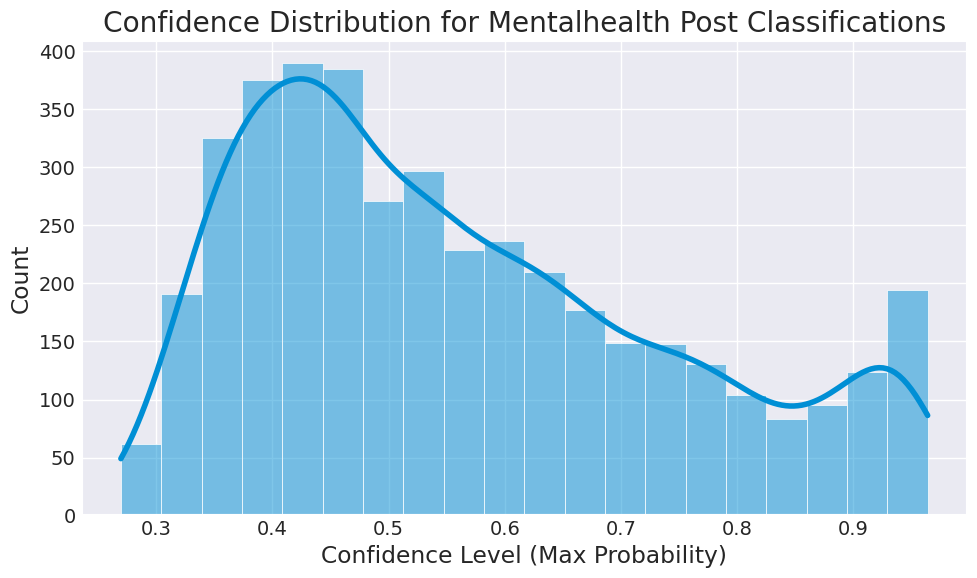

In [96]:
plt.figure(figsize=(10, 6))
sns.histplot(mentalhealth_df['confidence'], bins=20, kde=True)
plt.title('Confidence Distribution for Mentalhealth Post Classifications')
plt.xlabel('Confidence Level (Max Probability)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [97]:
high_confidence = mentalhealth_df[mentalhealth_df['confidence'] >= 0.8]
low_confidence = mentalhealth_df[mentalhealth_df['confidence'] < 0.5]

In [98]:
print(f"\nHigh confidence predictions (>=80%): {len(high_confidence)} posts ({len(high_confidence)/len(mentalhealth_df)*100:.2f}%)")
print(f"Low confidence predictions (<50%): {len(low_confidence)} posts ({len(low_confidence)/len(mentalhealth_df)*100:.2f}%)")


High confidence predictions (>=80%): 566 posts (13.55%)
Low confidence predictions (<50%): 1899 posts (45.46%)


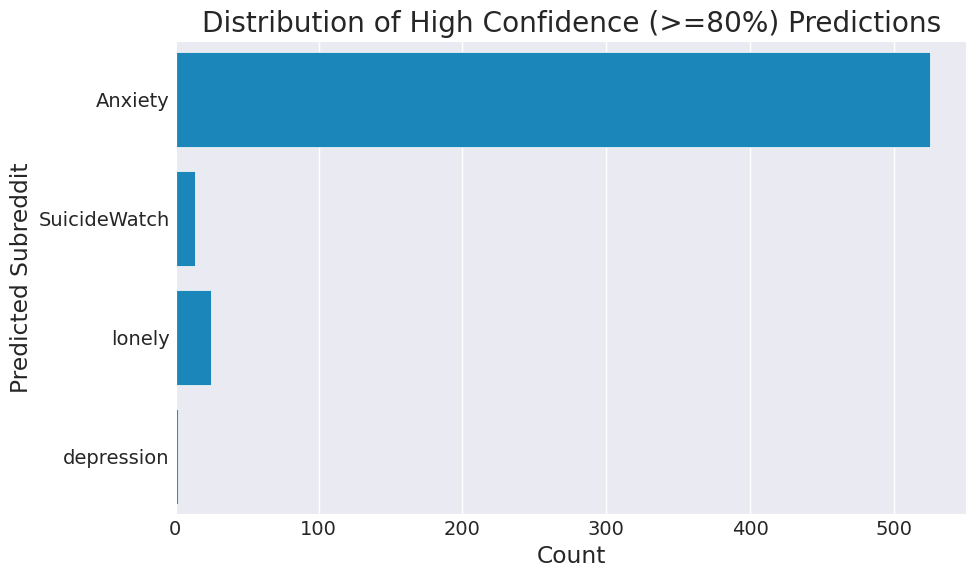

In [99]:
if len(high_confidence) > 0:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='predicted_subreddit', data=high_confidence)
    plt.title('Distribution of High Confidence (>=80%) Predictions')
    plt.xlabel('Count')
    plt.ylabel('Predicted Subreddit')
    plt.tight_layout()
    plt.show()

In [101]:
SAVE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'classifications', 'ensemble_classification.csv')
mentalhealth_df.to_csv(SAVE_PATH, index=False)